In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
post_likes = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-alibekov/personal/csv_files/post_likes.csv')

In [3]:
post_likes.head()

,id,button,likes
0,S001,red,160
1,S002,red,150
2,S003,red,150
3,S004,red,150
4,S005,red,187


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


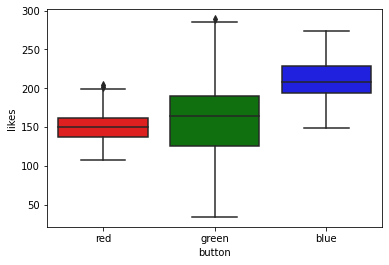

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
# boxplot

sns.boxplot(data = post_likes, x = 'button', y = 'likes', palette = ['r', 'g', 'b'])

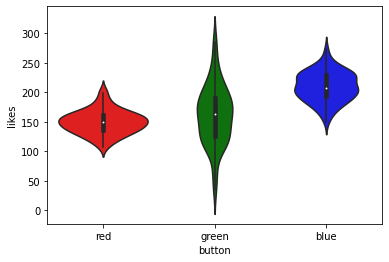

In [5]:
# violinplot

sns.violinplot(data = post_likes, x = 'button', y = 'likes', palette = ['r', 'g', 'b'])

### f_oneway // oneway ANOVA // Однофакторный дисперсионный анализ

In [6]:
# using scipy

red = post_likes.query('button == "red"').likes
green = post_likes.query('button == "green"').likes
blue = post_likes.query('button == "blue"').likes

In [7]:
ss.f_oneway(red, green, blue)

# межгрупповая дисперсия примерно в 86 раз больше, чем внутригрупповая
# красная, зеленая и голубая группа между собой различаются, так как pvalue < 0.05

F_onewayResult(statistic=85.99631112614011, pvalue=3.4370045810218544e-30)

In [8]:
# using statsmodels

model = smf.ols(formula = "likes ~ C(button)", data = post_likes).fit()
anova_lm(model)

# likes – зависимая переменная (ищем в ней различия)
# button – независимая переменная
# C – categorical

# C(button) – про межгрупповую группу квадратов
# Residual – про внутрисуммовую группу квадратов

,df,sum_sq,mean_sq,F,PR(>F)
C(button),2.0,201960.286667,100980.143333,85.996311,3.437005e-30
Residual,297.0,348748.710000,1174.238081,NaN,NaN


In [9]:
# using pingouin

pg.anova(data=post_likes, dv='likes', between='button', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,button,201960.286667,2,100980.143333,85.996311,3.437005e-30,0.366728
1,Within,348748.710000,297,1174.238081,NaN,NaN,NaN


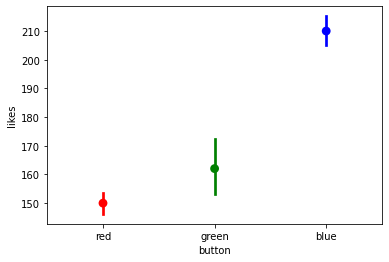

In [10]:
# средние с доверительными интервалами

sns.pointplot(data = post_likes, x = 'button', y = 'likes', palette = ['r', 'g', 'b'])

### Тестирование нормальности 

In [11]:
# using scipy 

print(ss.shapiro(red))
print(ss.shapiro(green))
print(ss.shapiro(blue))

# более чувствительный к выборкам большего размера

ShapiroResult(statistic=0.988104522228241, pvalue=0.515945315361023)
ShapiroResult(statistic=0.9887180328369141, pvalue=0.5625539422035217)
ShapiroResult(statistic=0.9937936663627625, pvalue=0.9309920072555542)


In [12]:
# another one

print(ss.normaltest(red))
print(ss.normaltest(green))
print(ss.normaltest(blue))

NormaltestResult(statistic=1.8343585907539965, pvalue=0.3996447324611219)
NormaltestResult(statistic=0.6727062715909409, pvalue=0.7143707913703767)
NormaltestResult(statistic=0.4606964500747045, pvalue=0.7942569741771747)


In [13]:
# using pingouin

pg.normality(data=post_likes, dv='likes', group='button', method='normaltest', alpha=0.05)

,W,pval,normal
red,1.834359,0.399645,True
green,0.672706,0.714371,True
blue,0.460696,0.794257,True


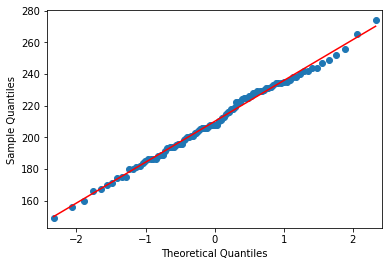

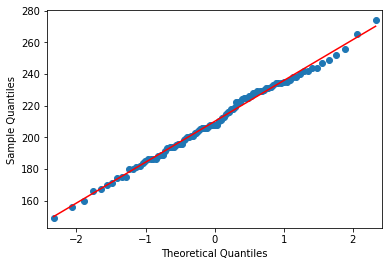

In [14]:
# qqplots (квантиль-квантиль графики)

sm.qqplot(blue, line='r')

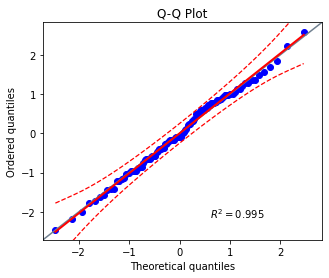

In [15]:
pg.qqplot(blue)

# плюс, что рисует границы доверительных интервалов, если точки выходят за границы, то ненормальное распределение

### Тестирование различий в дисперсиях

In [16]:
# using scipy 

ss.levene(red, green, blue)

LeveneResult(statistic=35.214282435572876, pvalue=1.8886636651084242e-14)

In [17]:
# using pingouin 

pg.homoscedasticity(data=post_likes, dv='likes', group='button')

,W,pval,equal_var
levene,35.214282,1.888664e-14,False


In [18]:
# если дисперсии разные, используем метод ANOVA Уэлча

pg.welch_anova(data=post_likes, dv='likes', between='button')

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,182.958104,177.856578,1.255660e-43,0.366728


### Множественные сравнения

In [19]:
from scipy.special import comb

In [20]:
comb(3, 2)

3.0

In [21]:
1 - 0.95**3

0.1426250000000001

In [22]:
pg.pairwise_ttests(data=post_likes, dv='likes', between='button')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,1.583,0.315609


In [23]:
2.619001e-02

0.02619001

### Если мы сильно боимся совершить ошибку, то выбираем самый консервативный метод – Бонферрони

In [24]:
pg.pairwise_ttests(data=post_likes, dv='likes', between='button', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,7.685599e-15,bonf,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,bonf,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,7.857004e-02,bonf,1.583,0.315609


In [25]:
7.857004e-02

# зеленые и красные группы различаются не так уж и значимо, ориентируясь на поправку Бонферрони
# holm

0.07857004

In [26]:
pg.pairwise_tukey(data=post_likes, dv='likes', between='button')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,blue,green,210.03,162.02,48.01,4.846108,9.906919,0.001000,1.395736
1,blue,red,210.03,149.96,60.07,4.846108,12.395514,0.001000,1.746342
2,green,red,162.02,149.96,12.06,4.846108,2.488595,0.035581,0.350606


In [27]:
# Games-Howell : поправка на то, что группы могут иметь разные дисперсии !!! 

pg.pairwise_gameshowell(data=post_likes, dv='likes', between='button')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,blue,green,210.03,162.02,48.01,5.588343,8.591097,145.583529,0.001000,1.210357
1,blue,red,210.03,149.96,60.07,3.200454,18.769214,188.902921,0.001000,2.644301
2,green,red,162.02,149.96,12.06,5.383475,2.240189,129.889834,0.068387,0.315609


In [28]:
pairwise_tukeyhsd(post_likes.likes, post_likes.button).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


In [29]:
MultiComparison(post_likes.likes, post_likes.button).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


### Многофакторный ANOVA

In [30]:
ads_clicks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-alibekov/personal/csv_files/ads_clicks.csv')

In [31]:
ads_clicks.head()

,id,ads,age_group,clicks
0,S001,classic,18-27,40
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39


In [32]:
model_main = smf.ols('clicks ~ C(ads) + C(age_group)', data=ads_clicks).fit()
anova_lm(model_main)

# главные эффекты – это то как влияют эти факторы независимо друг от друга

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,68.810244,7.245176e-16
C(age_group),2.0,400495.163333,200247.581667,408.450696,1.950084e-112
Residual,596.0,292195.753333,490.261331,NaN,NaN


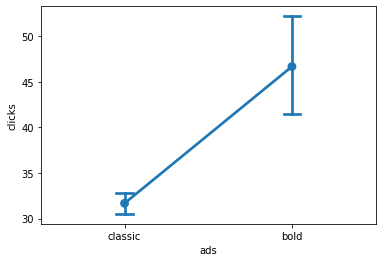

In [33]:
# первый фактор

sns.pointplot(x='ads', y='clicks', data=ads_clicks, capsize=0.1)

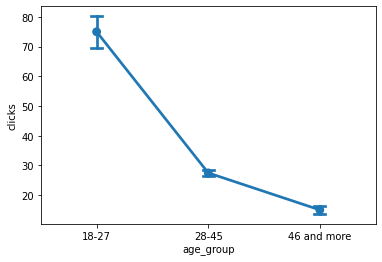

In [34]:
# второй фактор

sns.pointplot(x='age_group', y='clicks', data=ads_clicks, capsize=0.1)

In [35]:
# проверка взаимодействия факторов

model_interact = smf.ols('clicks ~ C(ads)*C(age_group)', data=ads_clicks).fit()
anova_lm(model_interact)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,336.722432,6.446773e-60
C(age_group),2.0,400495.163333,200247.581667,1998.750536,1.636934e-264
C(ads):C(age_group),2.0,232685.043333,116342.521667,1161.260853,5.618312e-206
Residual,594.0,59510.710000,100.186380,NaN,NaN


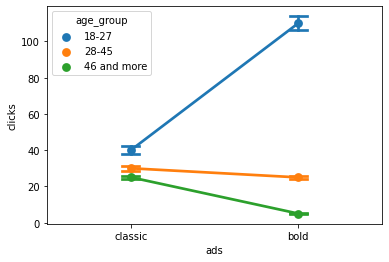

In [36]:
sns.pointplot(x='ads', y='clicks', hue='age_group', data=ads_clicks, capsize=0.1)